In [1]:
import random
import csv
import bs4
import pandas as pd
import numpy as np
import time
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor
from datetime import datetime
from selenium import webdriver
from IPython.display import clear_output, display
from selenium.webdriver.common.by import By 
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions as EC 
from selenium.common.exceptions import TimeoutException

<font color='black' size=6><u> **Navigate AllTrails.com and extract all CA hikes** </u></font>

Implement code to  <font color='green'> **extract all hike urls in CA**</font> from AllTrails.com.

In [5]:
agent_list = []
with open('agent_list.csv', 'r') as f:
    reader = csv.reader(f, delimiter=',')
    for r in reader:
        for agent in r:
            agent_list.append(agent)

def open_chrome():
    option = webdriver.ChromeOptions()
    option.add_argument(' — incognito')
    user_agent = random.choice(agent_list)
    option.add_argument(f'user-agent={user_agent}')
    browser = webdriver.Chrome(executable_path='/Users/stefanheinze/Desktop/chromedriver', options=option)
    
    return browser

In [6]:
def progress_display(current_value, iterable, start_time):
    current_index = iterable.index(current_value)
    current_time = datetime.now()
    delta_time = (current_time - start_time).total_seconds()
    clear_output(wait=True)
    print(str(current_index) + '/' + str(len(iterable)) + ' (' + str(round(current_index/len(iterable)*100, 1)) + '%)')  # use display(f) if you encounter performance issues
    print(str(int(delta_time)) + ' seconds have elapsed.')
    print('Expected time remaining is ' + str(int((len(iterable) - current_index) * (delta_time / current_index))) + ' seconds.')

In [7]:
def load_all_hikes():
    '''Loads the California section of AllTrails.com and clicks through
    the "Load More Hikes" button until it no longer appears (i.e. all
    hikes are loaded.
    
    Returns HTML soup.'''
    
    browser = open_chrome()
    browser.get('https://www.alltrails.com/us/california')
    
    # Wait 20 seconds for page to load
    timeout = 20
    try:
        WebDriverWait(browser, timeout).until(EC.visibility_of_element_located((By.XPATH, '//*[@id="load_more"]/a/div/h3')))
    except TimeoutException:
        print('Timed out waiting for page to load')
        browser.quit()
    
    count = 0
    start_time = datetime.now()
    while True:
        try:
            WebDriverWait(browser, timeout).until(EC.visibility_of_element_located((By.XPATH,'//*[@id="load_more"]/a/div/h3')))
            load_more_button = browser.find_element_by_xpath('//*[@id="load_more"]/a/div/h3')
            browser.execute_script("arguments[0].scrollIntoView()", load_more_button)
            time.sleep(1)
            load_more_button.click()
            count += 24
            progress_display(count, range(8200), start_time=start_time)
            time.sleep(random.uniform(0,2))
        except Exception as e:
            print(e)
            break

    soup = bs4.BeautifulSoup(browser.page_source)
    
    return soup

In [8]:
def extract_hike_urls(soup):
    '''Extracts hike links from the fully loaded AllTrails.com California webpage.
    
    Returns hike urls in a list.'''
    
    hikes_html = soup.find_all('h3', class_='name xlate-none short')
    #hike_names = [ hike.text for hike in hikes_html ]
    hike_hrefs = [ hike.find('a')['href'] for hike in hikes_html ]
    hike_urls = [ 'https://www.alltrails.com' + href for href in hike_hrefs ]
    
    return hike_urls

In [9]:
def save_list(listname, filename):
    '''Saves list to csv, with each item in the same row separated by a comma.'''
    
    with open(filename, 'w') as f:
        writer = csv.writer(f)
        for item in listname:
            writer.writerow([str(item)])

In [139]:
soup = load_all_hikes()
hike_urls = extract_hike_urls(soup)
save_list(hike_urls, 'hike_urls.csv')

8184/8200 (99.8%)
3629 seconds have elapsed.
Expected time remaining is 7 seconds.
8208 is not in range


# Extract data from hike

Implement code to  <font color='green'> **extract hike data from hike urls**</font>.

In [2]:
def load_hike_page(hike_link):
    '''
    Loads webpage for a given hike on AllTrails.com and loads all reviews by 
    clicking through the "Load More Reviews" button.
    
    Returns HTML of webpage.
    '''
    
    browser = open_chrome()
    browser.get(hike_link)

    # Wait 20 seconds for page to load
    timeout = 30
    try:
        WebDriverWait(browser, timeout).until(EC.visibility_of_element_located((By.XPATH, '//*[@id="main-photo"]/div[1]')))
    except TimeoutException:
        print('Timed out waiting for page to load')
        browser.quit()

    # Load all reviews
    while True:
        try:
            WebDriverWait(browser, 5).until(EC.visibility_of_element_located((By.XPATH,'//*[@id="load_more"]/div[2]/h3')))
            load_more_button = browser.find_element_by_xpath('//*[@id="load_more"]/div[2]/h3')
            browser.execute_script("arguments[0].scrollIntoView()", load_more_button)
            time.sleep(1)
            load_more_button.click()
            time.sleep(random.uniform(0,1))
        except:
            break

    soup = bs4.BeautifulSoup(browser.page_source)
    browser.close()

    return soup

In [10]:
def extract_hike_data(soup):
    '''
    Extract the following data for a single hike on AllTrails.com:
    
       Variable (type)
     - hike_name (str)
     - hike_difficulty (str)
     - hike_distance (str)
     - hike_elevation (str)
     - hike_type (str)
     - hike_tags (list of str)
     - hike_description (str)
     - user_names (list of str)
     - user_hrefs (list of str)
     - user_texts (list of str)
     - user_ratings (list of int)
     - user_dates (list of datetimes)
     
     Returns a dict with the above keys.
    '''
    
    # Get hike name
    try:
        hike_name = soup.find('title').text
    except:
        hike_name = None
    
    # Get hike difficulty
    try:
        hike_difficulty = soup.find('div', id='difficulty-and-rating').find('span').text
    except:
        hike_difficulty = None
    
    # Get hike distance, elevation, and type
    try:
        dist_elev_type = soup.find_all('div', class_='detail-data')
        hike_distance = dist_elev_type[0].text
        hike_elevation = dist_elev_type[1].text
        hike_type = dist_elev_type[2].text
    except:
        hike_distance = None
        hike_elevation = None
        hike_type = None
    
    # Get tags associated with hike
    try:
        tag_data = soup.find_all('span', class_='big rounded active')
        hike_tags = []
        for tag in tag_data:
            hike_tags.append(tag.text)
    except:
        hike_tags = None
    
    # Get hike description
    try:
        hike_description = soup.find('p', class_='xlate-google').text
    except:
        hike_description = None
    
    # Get user names and hrefs (which serve as unique ID)
    try:
        reviewer_info = soup.find_all('span', itemprop='author')
        user_names = [ item.text for item in reviewer_info ]
        user_hrefs = []
        for item in reviewer_info:
            # Some users don't have an ID
            try:
                user_hrefs.append(item.parent['href'])
            except:
                user_hrefs.append(None)
    except:
        user_names = None
        user_hrefs = None
    
    # Get user ratings
    try:
        reviews_html = soup.find_all('meta', itemprop='ratingValue')
        user_ratings = [ int(item['content']) for item in reviews_html[1:] ]
    except:
        user_ratings = None
    
    # Get user review publish dates
    try:
        publish_html = soup.find_all('meta', itemprop='datePublished')
        user_dates = [ datetime.strptime(item['content'], '%Y-%m-%d') for item in publish_html ]
    except:
        user_dates = None
    
    # Get user review text
    try:
        text_html = soup.find_all('p', itemprop='reviewBody')
        user_texts = [ item.text for item in text_html ]
    except: user_texts = None
    
    # Create dictionary with all scraped information
    hike_info_dict = {}
    hike_info_dict['hike_name'] = hike_name
    hike_info_dict['hike_difficulty'] = hike_difficulty
    hike_info_dict['hike_distance'] = hike_distance
    hike_info_dict['hike_elevation'] = hike_elevation
    hike_info_dict['hike_type'] = hike_type
    hike_info_dict['hike_tags'] = hike_tags
    hike_info_dict['hike_description'] = hike_description
    hike_info_dict['user_names'] = user_names
    hike_info_dict['user_hrefs'] = user_hrefs
    hike_info_dict['user_texts'] = user_texts
    hike_info_dict['user_ratings'] = user_ratings
    hike_info_dict['user_dates'] = user_dates

    return hike_info_dict

In [13]:
def save_progress(hike_info_dict, filename):
    '''
    Saves scraped dictionary (hike_info_dict) to a csv file (filename) using pandas
    '''
    
    try:
        hike_df = pd.read_pickle(filename)
        hike_df = hike_df.append(pd.DataFrame([hike_info_dict], columns=hike_info_dict.keys()))
        hike_df.to_pickle(filename)
    except FileNotFoundError: # first write to file
        hike_df = pd.DataFrame([hike_info_dict], columns=hike_info_dict.keys())
        hike_df.to_pickle(filename)

In [16]:
def executor_func(url, filename):
    soup = load_hike_page(url)
    hike_info_dict = extract_hike_data(soup)
    save_progress(hike_info_dict, filename)

In [ ]:
with ProcessPoolExecutor(max_workers=6) as executor:
    future_results = {executor.submit(executor_func, url=url, filename='hike_data_pickle'): url for url in hike_urls[203:]}

Timed out waiting for page to load
Timed out waiting for page to load
Timed out waiting for page to load
Timed out waiting for page to load
Timed out waiting for page to load
Timed out waiting for page to load
Timed out waiting for page to load
Timed out waiting for page to load
Timed out waiting for page to load
Timed out waiting for page to load
Timed out waiting for page to load
Timed out waiting for page to load
Timed out waiting for page to load
Timed out waiting for page to load
Timed out waiting for page to load
Timed out waiting for page to load
Timed out waiting for page to load
Timed out waiting for page to load
Timed out waiting for page to load
Timed out waiting for page to load
Timed out waiting for page to load
Timed out waiting for page to load
Timed out waiting for page to load
Timed out waiting for page to load
Timed out waiting for page to load
Timed out waiting for page to load
Timed out waiting for page to load
Timed out waiting for page to load
Timed out waiting fo

## Read hike_urls

In [18]:
urls_df = pd.read_csv('hike_urls.csv')
hike_urls = [ url[0] for url in urls_df.values ]

## Make agent list

In [711]:
browser = webdriver.Chrome(executable_path='/Users/stefanheinze/Desktop/chromedriver', options=option)
browser.get('http://useragentstring.com/pages/useragentstring.php?name=All')

In [716]:
soup = bs4.BeautifulSoup(browser.page_source)
user_agents = [ agent.text for agent in soup.find_all('a') ][5:]

In [767]:
save_list(user_agents, 'agent_list.csv')

<font size=4 color='green'><u>Many Tests</u></font>  
This is a **test!**  
This is *another* test!  
And ***another!***

Question: This markdown is a...?  
(a) test  
(b) *test*  
(c) **test**  
(d) ***test***

It's obviously an ~~exam~~

...one last test...

`Test == Test`

In [110]:
hike_data = pd.read_pickle('all_hike_data')

In [111]:
num_ratings = {}
for num in range(0,1000):
    num_ratings[num] = (hike_data['user_ratings'].apply(len) == num).sum()

In [112]:
import matplotlib.pyplot as plt

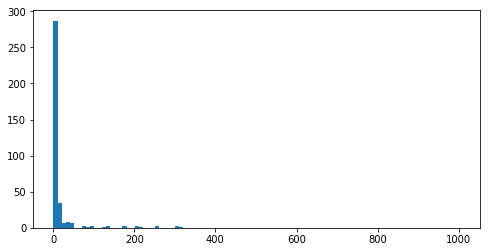

In [113]:
bins=np.arange(1,1010,10)
fig = plt.figure(figsize=(8,4))
plt.hist(num_ratings.values(), bins=bins);

In [114]:
hrefs = pd.Series(test['user_hrefs'].sum())

In [115]:
print(str(test.shape[0]) + ' hikes')
print(str(len(hrefs.unique())) + ' unique users')
print(str((hrefs.isnull() == False).sum()) + ' text reviews.')

sparsity = 226618 / (5367*105535) * 100
print('sparsity = ' + str(sparsity))

5367 hikes
105535 unique users
226618 text reviews.
sparsity = 0.0400097919100818


In [116]:
test_dict = {'a': {'1': 'this', '2': 'is'}, 'b': {'2': 'a', '3': 'test.'}}

In [117]:
pd.DataFrame(test_dict)

,a,b
1,this,NaN
2,is,a
3,NaN,test.
